# RSA Figures for Paper — Phosphenes vs VGG conv5_3

This notebook loads saved RSA results (CSV) and generates publication-ready figures focusing on **phosphene methods vs VGG conv5_3** (no feature-space).
It also includes helpers for the fused-layers case (mean of conv3_3/conv4_3/conv5_3) when available.

**What you'll get:**
- Clean bar plots of Spearman's ρ with 95% bootstrap CIs.
- Tables with Holm-corrected permutation p-values.
- Optional fused-layers plot if a corresponding CSV is present.

> Paths are configurable in the cell below.


In [16]:
# --- CONFIG ---
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Base directories where your results live
BASE = Path('../outRDM')

DATASETS = {
    'LaPa': BASE / 'LaPa' / 'allvgg',
    'SUN':  BASE / 'SUN'  / 'allvgg',
    'COCO': BASE / 'COCO' / 'allvgg',
}

# File names we expect per dataset
# FILE_VGG_53 = 'rsa_results_vgg_conv5_3.csv'
FILE_PIXEL   = 'rsa_results.csv'
FILE_VGG_FUSED = 'rsa_results_vgg_fused_mean_conv3_3-conv4_3-conv5_3.csv'

METHOD_ORDER = ['grayscale','DoG_adaptive','DoG_fixed_mean','DoG_fixed_small','canny_edge','random']
PRETTY = {
    'grayscale':'Grayscale',
    'DoG_adaptive':'DoG (Adaptive)',
    'DoG_fixed_mean':'DoG (Fixed-Mean)',
    'DoG_fixed_small':'DoG (Fixed-Small)',
    'canny_edge':'Canny Edge',
    'random':'Random'
}

plt.rcParams.update({
    'figure.dpi': 160,
    'font.size': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
})


In [17]:
BASE = Path('../outRDM')
# check if exist
if not BASE.exists():
    raise FileNotFoundError(f"Base directory {BASE} does not exist.")

In [18]:
from pathlib import Path

def load_rsa_csv(path: Path, filename: str):
    f = path / filename
    if f.exists():
        df = pd.read_csv(f)
        # Expect columns: method,rho,lo,hi,p_perm,p_holm
        assert 'method' in df.columns and 'rho' in df.columns, f'Missing expected columns in {f}'
        return df
    return None

def gather_datasets(dct_dirs, filename):
    rows = []
    for ds, p in dct_dirs.items():
        df = load_rsa_csv(p, filename)
        if df is not None:
            df['dataset'] = ds
            rows.append(df)
    if rows:
        out = pd.concat(rows, ignore_index=True)
        out['method'] = pd.Categorical(out['method'], categories=METHOD_ORDER, ordered=True)
        out = out.sort_values(['dataset','method']).reset_index(drop=True)
        return out
    return None


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bars_rho_ci(df, title: str, savepath: Path = None):
    datasets = list(df['dataset'].unique())
    n = len(datasets)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4), sharey=True)
    if n == 1:
        axes = [axes]
    for ax, ds in zip(axes, datasets):
        sub = df[df['dataset'] == ds].copy()
        sub = sub.set_index('method').reindex(METHOD_ORDER).reset_index()
        x = np.arange(sub.shape[0])
        rho = sub['rho'].values
        lo  = sub['lo'].values if 'lo' in sub else (rho*0)
        hi  = sub['hi'].values if 'hi' in sub else (rho*0)
        err_low  = rho - lo
        err_high = hi - rho
        labels = [PRETTY.get(m, m) for m in sub['method'].tolist()]
        ax.bar(x, rho, yerr=[err_low, err_high], capsize=3)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=30, ha='right')
        ax.set_title(ds)
        ax.set_ylabel('Spearman ρ')
        ax.set_ylim([-0.05, max(0.01, np.nanmax(hi)+0.05)])
    fig.suptitle(title)
    fig.tight_layout()
    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(savepath, bbox_inches='tight')
    plt.show()

def table_pvalues(df):
    cols = [c for c in ['dataset','method','rho','p_perm','p_holm'] if c in df.columns]
    t = df[cols].sort_values(['dataset','method']).reset_index(drop=True)
    return t


# Make plots

In [107]:
import pandas as pd

dfs = []
for dataset in ["COCO", "LaPa", "SUN"]:
    path = f"../outRDM/{dataset}/allvgg/rsa_results_vgg_fused_mean_conv3_3-conv4_3-conv5_3.csv"
    d = pd.read_csv(path)
    d["dataset"] = dataset
    d["dissim"] = 1 - d["rho"]
    d["dissim_lo"] = 1 - d["hi"]
    d["dissim_hi"] = 1 - d["lo"]
    dfs.append(d)

df_all = pd.concat(dfs, ignore_index=True)
# print(df_all.head())
methods = ['DoG_adaptive', 'DoG_fixed_small', 'grayscale', 'random', 'canny_edge']
pretty_names = ['SCAPE', 'DoG (fixed)', 'Grayscale', 'Random', 'Canny Edge']
df_all = df_all[df_all["method"].isin(methods)]
# replace method names with pretty names
df_all["method"] = df_all["method"].replace(dict(zip(methods, pretty_names)))

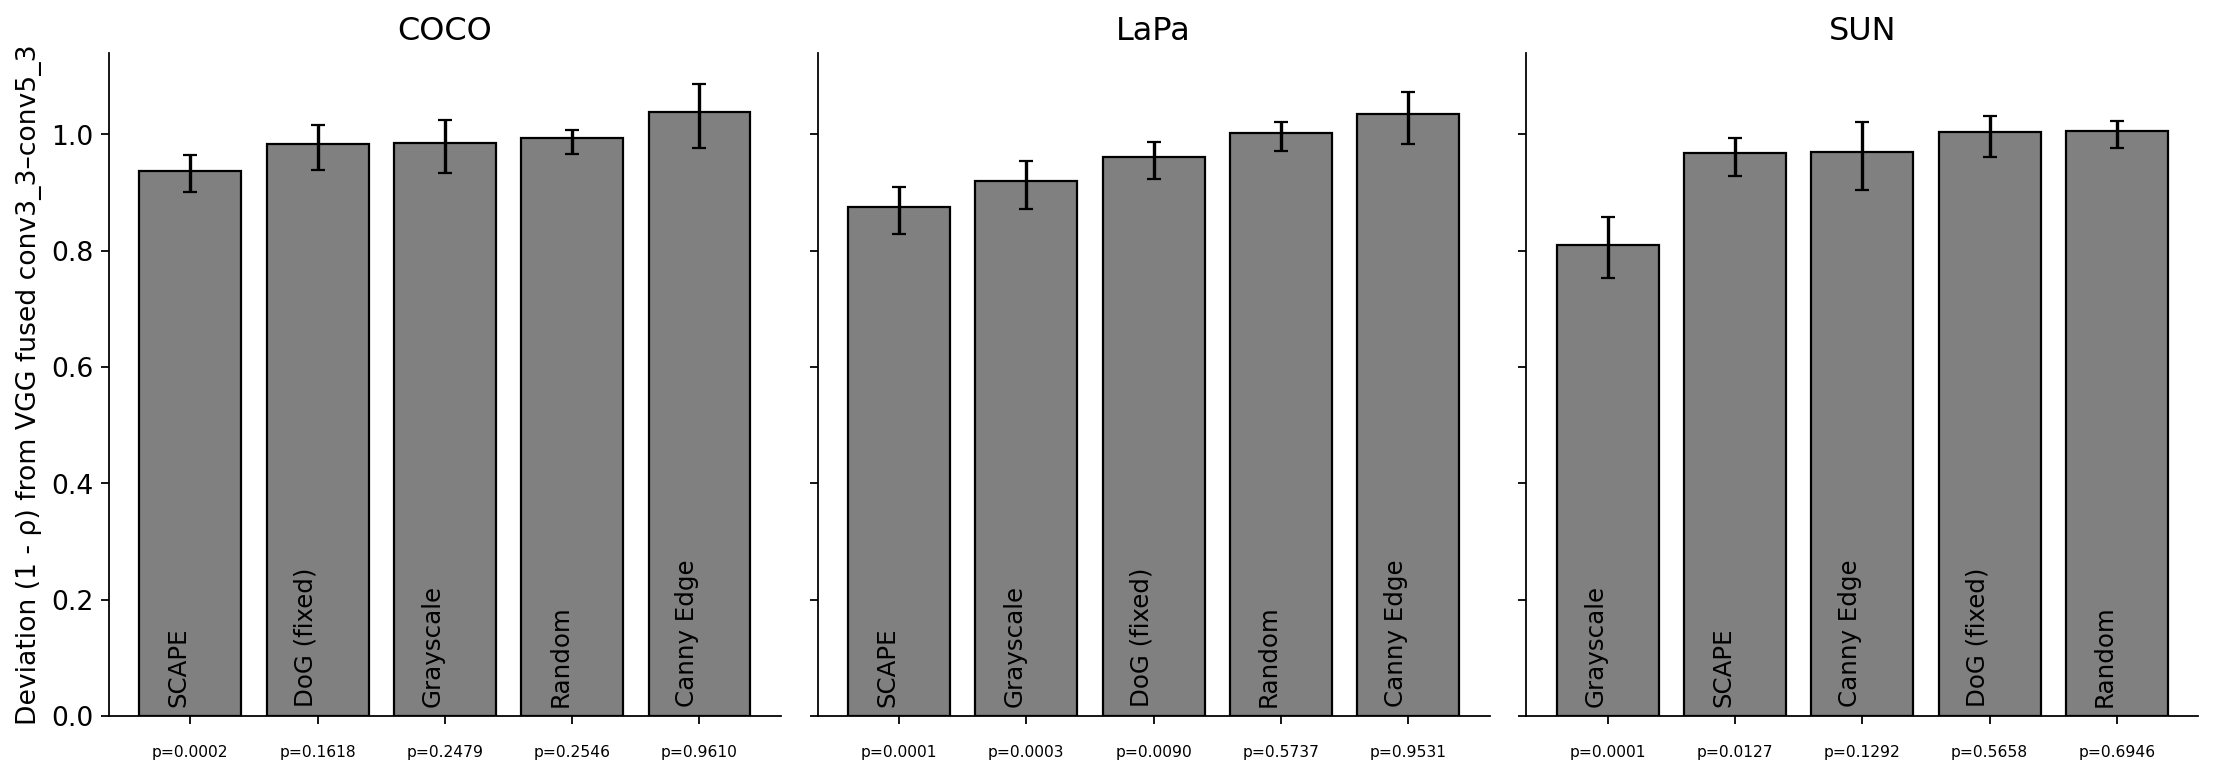

In [108]:
import matplotlib.pyplot as plt

datasets = df_all["dataset"].unique()
fig, axes = plt.subplots(1, len(datasets), figsize=(14,5), sharey=True)

for ax, ds in zip(axes, datasets):
    sub = df_all[df_all["dataset"] == ds].copy()
    sub = sub.sort_values("dissim")  # optional: best→worst

    bars = ax.bar(sub["method"], sub["dissim"], 
                  yerr=[sub["dissim"]-sub["dissim_lo"], sub["dissim_hi"]-sub["dissim"]],
                  capsize=3, color="gray", edgecolor="black")

    # annotate p-values
    for i, row in enumerate(sub.itertuples()):
        ax.text(i, -0.05, f"p={row.p_perm:.4f}", ha="center", va="top", fontsize=7)

    ax.set_title(ds)
    ax.set_xticks(range(len(sub)))
    ax.tick_params(axis="x", pad=-10)   # default ~4; larger = higher
    ax.set_xticklabels(sub["method"], rotation=90, ha="right", fontsize=11, verticalalignment='baseline')

axes[0].set_ylabel("Deviation (1 - ρ) from VGG fused conv3_3–conv5_3")
plt.tight_layout()
plt.show()


In [109]:
dfs = []
for dataset in ["COCO", "LaPa", "SUN"]:
    path = f"../outRDM/{dataset}/allvgg/rsa_results.csv"
    d = pd.read_csv(path)
    d["dataset"] = dataset
    d["dissim"] = 1 - d["rho"]
    d["dissim_lo"] = 1 - d["hi"]
    d["dissim_hi"] = 1 - d["lo"]
    dfs.append(d)

df_all = pd.concat(dfs, ignore_index=True)
# print(df_all.head())
methods = ['DoG_adaptive', 'DoG_fixed_small', 'grayscale', 'random', 'canny_edge']
df_all = df_all[df_all["method"].isin(methods)]

df_all = pd.concat(dfs, ignore_index=True)
# print(df_all.head())
methods = ['DoG_adaptive', 'DoG_fixed_small', 'grayscale', 'random', 'canny_edge']
pretty_names = ['SCAPE', 'DoG (fixed)', 'Grayscale', 'Random', 'Canny Edge']
df_all = df_all[df_all["method"].isin(methods)]
# replace method names with pretty names
df_all["method"] = df_all["method"].replace(dict(zip(methods, pretty_names)))

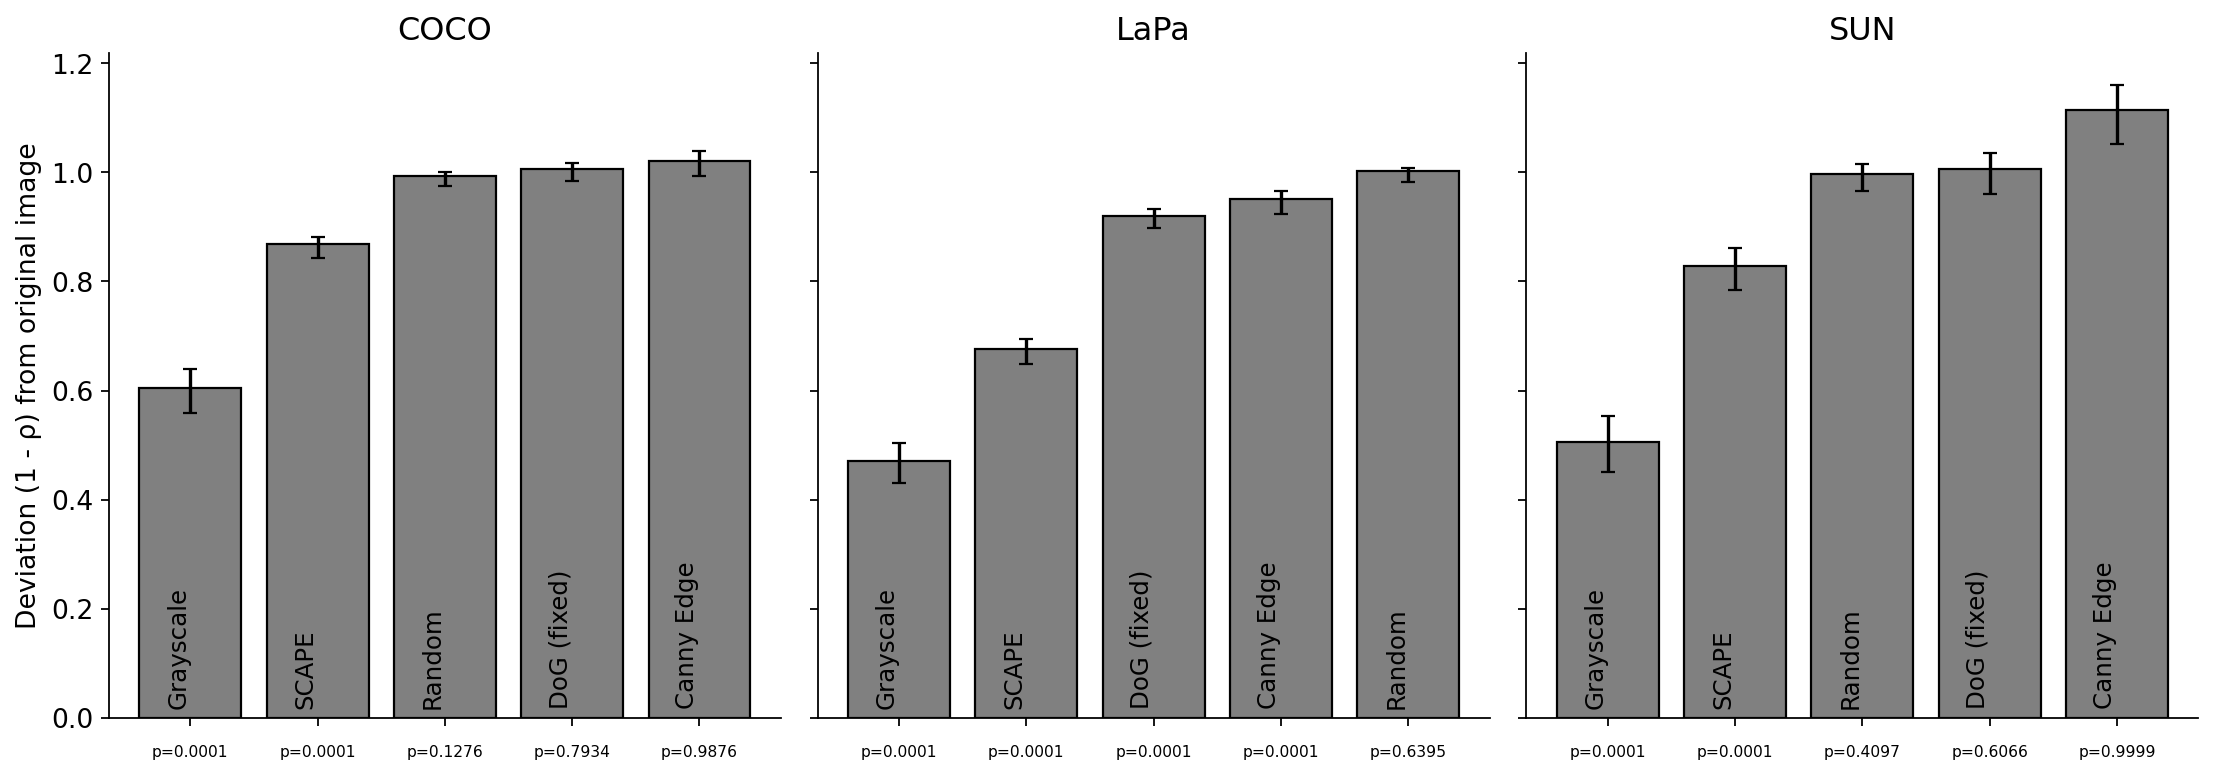

In [110]:
import matplotlib.pyplot as plt

datasets = df_all["dataset"].unique()
fig, axes = plt.subplots(1, len(datasets), figsize=(14,5), sharey=True)

for ax, ds in zip(axes, datasets):
    sub = df_all[df_all["dataset"] == ds].copy()
    sub = sub.sort_values("dissim")  # optional: best→worst

    bars = ax.bar(sub["method"], sub["dissim"], 
                  yerr=[sub["dissim"]-sub["dissim_lo"], sub["dissim_hi"]-sub["dissim"]],
                  capsize=3, color="gray", edgecolor="black")

    # annotate p-values
    for i, row in enumerate(sub.itertuples()):
        ax.text(i, -0.05, f"p={row.p_perm:.4f}", ha="center", va="top", fontsize=7)

    ax.set_title(ds)
    ax.set_xticks(range(len(sub)))
    ax.tick_params(axis="x", pad=-10)   # default ~4; larger = higher
    ax.set_xticklabels(sub["method"], rotation=90, ha="right", fontsize=11, verticalalignment='baseline')

axes[0].set_ylabel("Deviation (1 - ρ) from original image")
plt.tight_layout()
plt.show()


# New

In [77]:
# --- CONFIG & UTILS (Py3.8/3.9 safe) ---
from pathlib import Path
from typing import Optional
from pandas.api.types import CategoricalDtype

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Base results directory
BASE = Path('../outRDM')

# Datasets (folders under BASE)
DATASETS = {
    'LaPa': BASE / 'LaPa' / 'allvgg',
    'SUN':  BASE / 'SUN'  / 'allvgg',
    'COCO': BASE / 'COCO' / 'allvgg',
}

# Filenames (per scheme folder)
FILE_PIXEL      = 'rsa_results.csv'
FILE_VGG_FUSED  = 'rsa_results_vgg_fused_mean_conv3_3-conv4_3-conv5_3.csv'
# Optional (if you later want per-layer plots)
FILE_VGG_PERLAY = 'rsa_results_vgg_per_layer_conv3_3-conv4_3-conv5_3.csv'

# Method ordering & pretty names
METHOD_ORDER = ['DoG_adaptive', 'DoG_fixed_small', 'canny_edge', 'random']
PRETTY = {
    'DoG_adaptive':    'SCAPE',
    'DoG_fixed_small': 'DoG (fixed)',
    'grayscale':       'Grayscale',
    'canny_edge':      'Canny Edge',
    'random':          'Random'
}

plt.rcParams.update({
    'figure.dpi': 160,
    'font.size': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

In [92]:
def discover_schemes(ds_dir: Path):
    """
    Return a sorted list of scheme directories inside the dataset 'allvgg' folder.
    Only include directories that contain at least one RSA csv.
    Also supports legacy files directly in allvgg (then scheme='base').
    """
    if not ds_dir.exists():
        return []

    schemes = []
    for p in sorted(ds_dir.iterdir()):
        if p.is_dir():
            has_any = any((p / fn).exists() for fn in (FILE_PIXEL, FILE_VGG_FUSED, FILE_VGG_PERLAY))
            if has_any:
                schemes.append(p.name)

    # legacy: results directly in allvgg
    if any((ds_dir / fn).exists() for fn in (FILE_PIXEL, FILE_VGG_FUSED, FILE_VGG_PERLAY)):
        schemes = ['base'] + schemes

    return schemes

def load_rsa_one(path: Path) -> Optional[pd.DataFrame]:
    """
    Load an RSA csv if present; ensure required columns & add dissimilarities.
    """
    if not path.exists():
        return None
    df = pd.read_csv(path)
    if 'method' not in df.columns or 'rho' not in df.columns:
        return None

    # keep only methods we care about (and in fixed order)
    df = df[df['method'].isin(METHOD_ORDER)].copy()
    if df.empty:
        return None

    # dissimilarity and CI in dissimilarity space
    df['dissim'] = 1 - df['rho']
    if 'lo' in df.columns and 'hi' in df.columns:
        df['dissim_lo'] = 1 - df['hi']  # swap due to 1-ρ transform
        df['dissim_hi'] = 1 - df['lo']
    else:
        df['dissim_lo'] = df['dissim']
        df['dissim_hi'] = df['dissim']

    # p-values (if missing, fill NaN)
    for c in ['p_perm', 'p_holm']:
        if c not in df.columns:
            df[c] = np.nan

    # order & pretty labels
    df['method'] = pd.Categorical(df['method'], categories=METHOD_ORDER, ordered=True)
    df['method_pretty'] = df['method'].map(lambda m: PRETTY.get(m, str(m)))
    return df.sort_values('method')

def gather_all(metric='vgg'):
    """
    metric: 'vgg' -> FILE_VGG_FUSED, 'pixel' -> FILE_PIXEL
    Returns a tidy dataframe: dataset, scheme, method, method_pretty, dissim, dissim_lo, dissim_hi, p_perm, p_holm
    """
    fname = FILE_VGG_FUSED if metric == 'vgg' else FILE_PIXEL
    rows = []
    for ds, root in DATASETS.items():
        schemes = discover_schemes(root)
        if not schemes:
            print(f"[warn] no schemes found for {ds} at {root}")
        for sch in schemes:
            folder = root if sch == 'base' else (root / sch)
            df = load_rsa_one(folder / fname)
            if df is None:
                continue
            df = df.copy()
            df['dataset'] = ds
            df['scheme']  = sch
            rows.append(df)



    if not rows:
        return pd.DataFrame()

    out = pd.concat(rows, ignore_index=True)

    # Stable column orderings
    # Stable dataset order
    ds_order  = ['COCO','LaPa','SUN']
    out['dataset'] = pd.Categorical(out['dataset'], categories=ds_order, ordered=True)

    # Preferred scheme order (1024 first), then any others
    pref = ['defaultcoordinatemap_1024','neuralink','1utaharray','4utaharrays']
    present = out['scheme'].unique().tolist()
    sch_order = [s for s in pref if s in present]
    out['scheme'] = pd.Categorical(out['scheme'], categories=sch_order, ordered=True)

    schemes_pretty = ['default 1024', 'neuralink', '1 utah array', '4 utah arrays']
    out['scheme_pretty'] = out['scheme'].map(dict(zip(sch_order, schemes_pretty)))

    return out

In [105]:
def plot_grid(df: pd.DataFrame, title: str, savepath: Optional[Path] = None):
    """
    Grid: rows = schemes, cols = datasets.
    - Bars sorted best→worst (lower dissimilarity is better)
    - Asymmetric CI
    - Method name printed vertically just above the x-axis
    - Kriegeskorte-style p-values below bars (non-significant hidden), plus a left "p<"
    """
    if df.empty:
        print("Nothing to plot."); return

    # --- tweakables ---
    Y_SCALE         = 1.0
    P_SPACE_FRAC    = 0.00
    LABEL_OFF_FRAC  = 0.00
    P_PREFIX_X_AX   = -0.015
    P_TEXT_Y_AX     = -0.02       # y for the p-values (axes coords)
    BESTWORST_Y_AX  = -0.07       # y for "best"/"worst" (a bit below the p-values)
    P_THRESHOLDS    = (1e-4, 1e-3, 1e-2, 5e-2)
    P_STRINGS       = ("1e-4", "1e-3", ".01", ".05")
    # -------------------

    def format_p_kriegeskorte(p: float) -> str:
        if not np.isfinite(p):
            return ""
        for thr, s in zip(P_THRESHOLDS, P_STRINGS):
            if p < thr:
                return s
        return ""  # non-significant (>= .05) -> hide

    datasets = list(df['dataset'].cat.categories) if hasattr(df['dataset'].dtype, 'categories') else sorted(df['dataset'].unique())
    schemes  = list(df['scheme'].cat.categories)  if hasattr(df['scheme'].dtype,  'categories') else sorted(df['scheme'].unique())
    # pretty electrode names
    n_rows, n_cols = len(schemes), len(datasets)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 3.8*n_rows), sharey=True)
    if n_rows == 1 and n_cols == 1: axes = np.array([[axes]])
    elif n_rows == 1:               axes = axes.reshape(1, -1)
    elif n_cols == 1:               axes = axes.reshape(-1, 1)

    ymax  = np.nanmax(df['dissim_hi'].values) if 'dissim_hi' in df else np.nanmax(df['dissim'].values)
    y_top = max(0.01, float(ymax) * Y_SCALE)
    p_margin = P_SPACE_FRAC * y_top

    for r, sch in enumerate(schemes):
        for c, ds in enumerate(datasets):
            ax = axes[r, c]
            sub = df[(df['dataset']==ds) & (df['scheme']==sch)].copy()
            if sub.empty: ax.axis('off'); continue

            # best→worst
            sub = sub.set_index('method').reindex(METHOD_ORDER).reset_index()
            sub = sub.sort_values("dissim", ascending=True, kind="mergesort")

            x  = np.arange(sub.shape[0])
            y  = sub['dissim'].to_numpy(dtype=float)
            lo = sub['dissim_lo'].to_numpy(dtype=float)
            hi = sub['dissim_hi'].to_numpy(dtype=float)
            err_low  = np.clip(y - lo, 0, None)   # asymmetric lower
            err_high = np.clip(hi - y, 0, None)   # asymmetric upper

            bars = ax.bar(x, y, yerr=[err_low, err_high], capsize=3, color="gray", edgecolor="black")

            # === Kriegeskorte-style p-values under bars ===
            p_src  = sub['p_perm'].fillna(sub['p_holm']).to_numpy()
            nbar   = len(bars)

            # "p<" prefix once at the left
            ax.text(P_PREFIX_X_AX, P_TEXT_Y_AX, "p<", transform=ax.transAxes,
                    ha="right", va="top", fontsize=9, clip_on=False)

            # values under each bar (hide non-significant)
            for i, p in enumerate(p_src):
                label = format_p_kriegeskorte(p)  # uses your thresholds
                if not label:
                    continue
                x_ax = (i + 0.5) / max(1, nbar)  # bar center in axes coords
                ax.text(x_ax, P_TEXT_Y_AX, label, transform=ax.transAxes,
                        ha="center", va="top", fontsize=9, clip_on=False)
                

            # === "best" and "worst" under the x-axis ===
            # (list is sorted best→worst already)
            if nbar > 0:
                first_center = 0.5 / nbar
                last_center  = 1.0 - 0.5 / nbar
                ax.text(first_center, BESTWORST_Y_AX, "best",
                        transform=ax.transAxes, ha="center", va="top",
                        fontsize=9, style="italic", clip_on=False)
                ax.text(last_center, BESTWORST_Y_AX, "worst",
                        transform=ax.transAxes, ha="center", va="top",
                        fontsize=9, style="italic", clip_on=False)

            if r == 0: ax.set_title(ds)
            # scheme pretty name
            sch_pretty = df['scheme_pretty'].cat.categories[r] if hasattr(df['scheme_pretty'].dtype, 'categories') else sch
            if c == 0: ax.set_ylabel(f"{sch_pretty}\nDeviation (1 − ρ)")
            ax.set_xticks([])
            ax.set_ylim([-p_margin, y_top])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # method names just above x-axis (vertical), drawn in axes coords
            labels = sub['method_pretty'].tolist()
            nbar = len(bars)
            LABEL_Y_AX = 0.02   # 2% above the x-axis; tweak 0.015–0.03

            for i, lab in enumerate(labels):
                x_ax = (i + 0.5) / max(1, nbar)  # bar center in axes coords
                ax.text(x_ax, LABEL_Y_AX, lab,
                        transform=ax.transAxes,
                        ha='center', va='bottom',
                        rotation=90, fontsize= 11, color='white',
                        clip_on=False)



    fig.suptitle(title)
    fig.tight_layout(rect=(0,0,1,0.97))
    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(savepath, bbox_inches='tight')
    plt.show()


def export_summary(df: pd.DataFrame, out_csv: Path):
    if df.empty:
        return
    tab = (df[['dataset','scheme','method_pretty','dissim','dissim_lo','dissim_hi','p_perm','p_holm']]
           .rename(columns={'method_pretty':'method'}))
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    tab.to_csv(out_csv, index=False)
    print(f"Wrote {out_csv}")

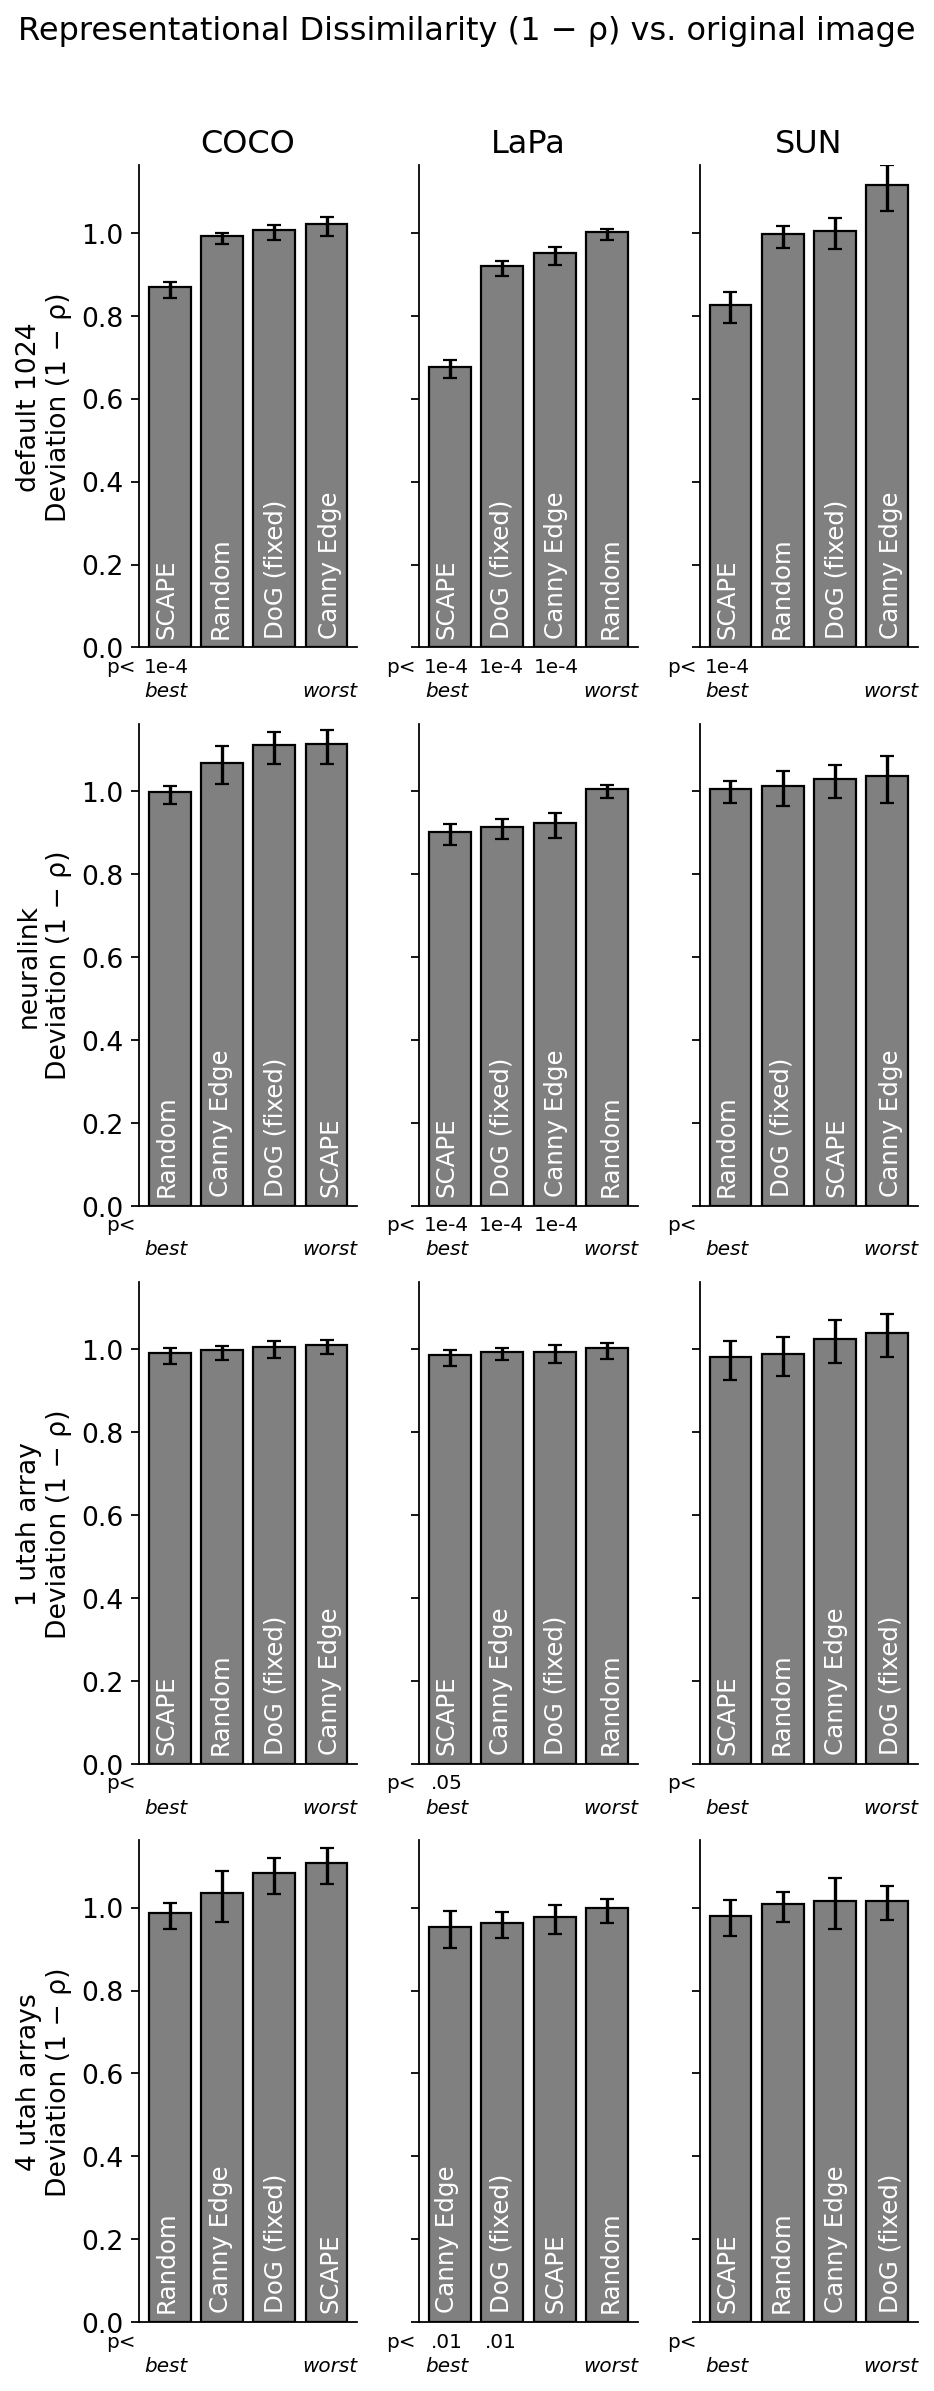

Wrote tables/rsa_pixel_summary.csv


In [106]:
# ---------- RUN ----------

# Pixel-space (original images)
df_pix = gather_all(metric='pixel')
plot_grid(df_pix, title="Representational Dissimilarity (1 − ρ) vs. original image",
          savepath=Path("./fig_rdm_pixel.png"))
export_summary(df_pix, Path("./tables/rsa_pixel_summary.csv"))

# # VGG-fused against conv3_3–conv5_3
# df_vgg = gather_all(metric='vgg')
# plot_grid(df_vgg, title="Representational Dissimilarity (1 − ρ) vs. VGG fused conv3_3–conv5_3",
#           savepath=Path("./fig_rdm_vgg_fused.png"))
# export_summary(df_vgg, Path("./tables/rsa_vgg_fused_summary.csv"))

